In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense,LSTM,Input,concatenate,Conv1D,Flatten
from keras.layers.pooling import MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.sequence import TimeseriesGenerator


/Users/kaba/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def make_ts(x,sequence_length):
    l = []
    cnt = 0
    while True:
        l.append(x[cnt:cnt+sequence_length])
        if len(x) < cnt + sequence_length+1:
            break
        cnt += 1
    X=np.array(l)

    if X.ndim == 2:
        X=X[:, :, np.newaxis]

    assert  X.ndim == 3
    return X

In [3]:
x=np.array(range(1250)).reshape([250,5])
print(make_ts(x,10).shape)

(241, 10, 5)


In [61]:

x1 = np.random.normal(size=[5]) 
x2 = np.random.normal(size=[5]) 

x=np.r_[np.tile(x1,1000).reshape([1000,5]),
      np.tile(x2,1000).reshape([1000,5])]

t = np.linspace(0,10,1000)
y = np.r_[np.sin(2*np.pi*t),np.sin(4*np.pi*t)]
y += np.random.normal(size=len(y))*0.1

y_prev = np.empty(2000)
y_prev[0] = 0
y_prev[1:] = y[:-1]

x = make_ts(x,100)
y_prev = make_ts(y_prev,100)
y = y[100-1:]

In [62]:
x.shape,y.shape,y_prev.shape

((1901, 100, 5), (1901,), (1901, 100, 1))

In [63]:

context_input = Input(shape=(100,5))
context_normalize = Dense(5,activation="relu")(context_input)
context_normalize = MaxPooling1D(2)(context_normalize)
context_normalize = MaxPooling1D(2)(context_normalize)

#previous_normalize = LSTM(20,return_sequences=True)(previous_output)
#previous_normalize = Dense(20)(previous_output)

previous_output = Input(shape=(100,1))
previous_normalize = Conv1D(10,3,padding="same",activation="relu")(previous_output)
previous_normalize = Conv1D(10,3,padding="same",activation="relu")(previous_normalize)
previous_normalize = MaxPooling1D(2)(previous_normalize)
previous_normalize = Conv1D(10,3,padding="same",activation="relu")(previous_normalize)
previous_normalize = Conv1D(10,3,padding="same",activation="relu")(previous_normalize)
previous_normalize = MaxPooling1D(2)(previous_normalize)

model_output = concatenate([context_normalize,previous_normalize])
model_output = Conv1D(100,3,padding="same",activation="relu")(model_output)
model_output = Conv1D(100,3,padding="same",activation="relu")(model_output)
model_output = MaxPooling1D(2)(model_output)

model_output = LSTM(30,return_sequences=False,activation="relu")(model_output)
#model_output = Flatten()(model_output)
model_output = Dense(1,activation="linear")(model_output)

model=Model([context_input,previous_output],model_output)
model.compile(loss="mse",optimizer="adam")

51451


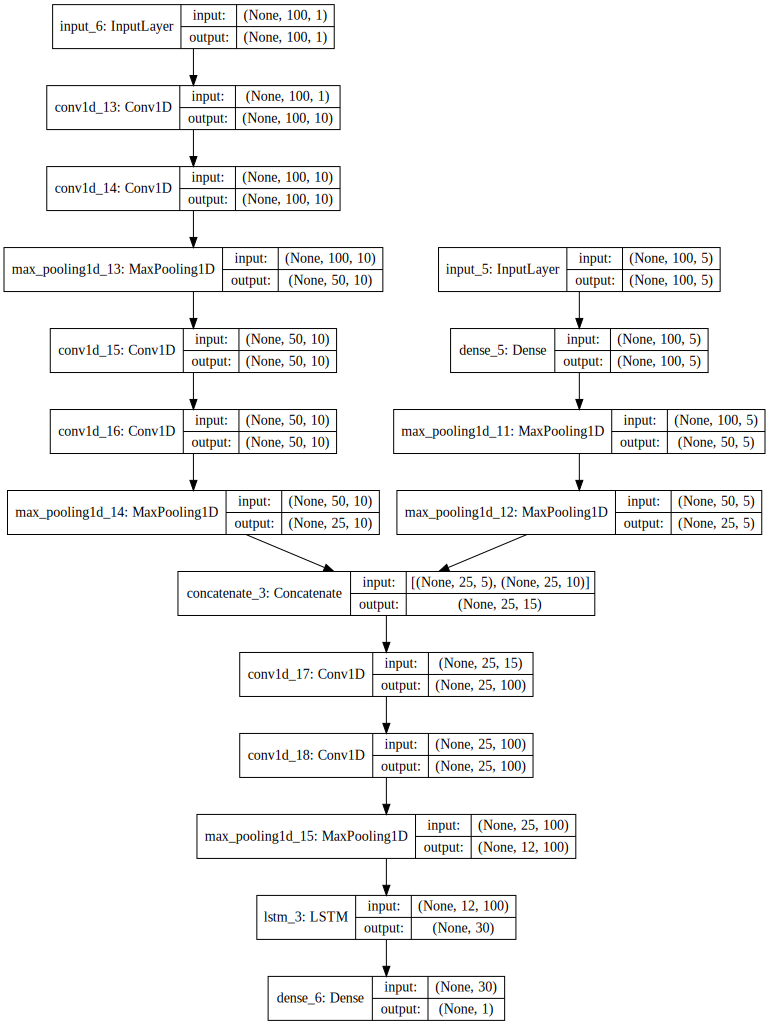

In [64]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#print(model.summary())
print(model.count_params())
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


In [65]:
model.fit([x,y_prev],y,epochs=30,validation_split=0.1)

Train on 1710 samples, validate on 191 samples
Epoch 1/30
1710/1710 [==============================] - 4s 2ms/step - loss: 0.3324 - val_loss: 0.0249
Epoch 2/30
1710/1710 [==============================] - 2s 1ms/step - loss: 0.0163 - val_loss: 0.0153
Epoch 3/30
1710/1710 [==============================] - 2s 924us/step - loss: 0.0147 - val_loss: 0.0122
Epoch 4/30
1710/1710 [==============================] - 2s 1ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 5/30
1710/1710 [==============================] - 2s 1ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 6/30
1710/1710 [==============================] - 2s 1ms/step - loss: 0.0137 - val_loss: 0.0201
Epoch 7/30
1710/1710 [==============================] - 1s 635us/step - loss: 0.0141 - val_loss: 0.0123
Epoch 8/30
1710/1710 [==============================] - 2s 1ms/step - loss: 0.0142 - val_loss: 0.0155
Epoch 9/30
1710/1710 [==============================] - 2s 1ms/step - loss: 0.0134 - val_loss: 0.0145
Epoch 10/30
1710/1710 [========

In [66]:

predict_input2 =list(y[:100])
#predict_input2 =[0]*100

l= []
for i in range(2000):
    if i < 1000:
        predict = model.predict([x[0].reshape([1,100,5]),np.array(predict_input2).reshape([1,100,1])])
    else:

        predict = model.predict([x[-1].reshape([1,100,5]),np.array(predict_input2).reshape([1,100,1])])
    predict_input2.pop(0)
    predict_input2.append(np.copy(predict))
    l.append(np.copy(predict))
    

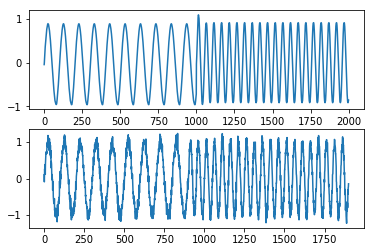

In [67]:
plt.subplot(2,1,1)
plt.plot(np.ravel(l))
plt.subplot(2,1,2)
plt.plot(y)

plt.show()